# Домашнее задание №3. Продвинутые архитектуры свёрточных нейросетей

In [46]:
%tensorflow_version 2.x

In [47]:
#загрузка необходимых библиотек и модулей
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Задание
Обучить СНС с помощью Transfer Learning на датасете Food-101.

Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

Библиотеки: [Python, Tensorflow]

## План решения
[0. Загрузка и просмотр данных](#section_0)

[1. Создание пайплайна данных](#section_1)

[2. Построение модели CNN](#section_2)

[3. Предсказание модели](#section_3)

### 0. Загрузка и просмотр данных <a id='section_0'></a>

Загрузка датасета

In [48]:
%%time

tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train', 'validation'],
)

CPU times: user 75.3 ms, sys: 1.96 ms, total: 77.3 ms
Wall time: 80 ms


In [49]:
#имена классов
class_names = ds_info.features['label'].names 
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [50]:
#количество классов
num_classes = ds_info.features['label'].num_classes
print(num_classes)

101


Визуализация датасета

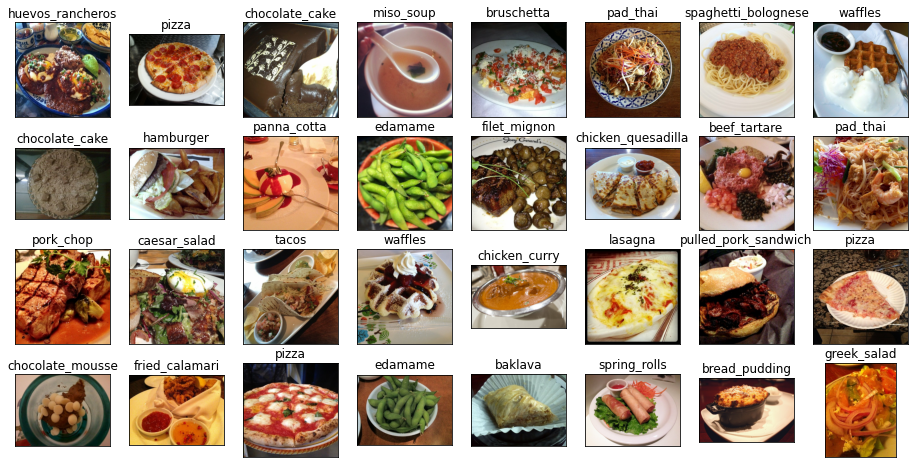

In [51]:
get_label_name = ds_info.features['label'].int2str
some_samples = [x for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][0])
    plt.title(get_label_name(some_samples[j][1].numpy()))
    plt.xticks([]), plt.yticks([])
plt.show()

### 1. Создание пайплайна данных <a id='section_1'></a>

In [52]:
INP_SIZE = 160

#слой предварительной обработки данных
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(INP_SIZE, INP_SIZE),
  tf.keras.layers.Rescaling(1./127.5, offset=-1)
])

#слой аугментации данных
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [53]:
#Применение слоев предварительной обработки и аугментации к наборам данных
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Изменение размера и масштаба всех наборов данных
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)

  # Создаем батчи для всех наборов данных
  ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Используем буферизованную предварительную выборку для всех наборов данных
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)

### 2. Построение модели CNN <a id='section_2'></a>

Создание модели

In [54]:
base_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet')

base_model.trainable = True # Fine-tuning весов предобученной модели
   
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101),
])

Подготовка к обучению

In [55]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/fine_tune', 
    write_graph=False, update_freq=100, profile_batch=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model summary

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               206949    
                                                                 
Total params: 23,794,661
Trainable params: 23,741,541
Non-trainable params: 53,120
_________________________________________________________________


Обучение модели

In [57]:
%%time
NUM_EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10
2368/2368 [==============================] - 552s 230ms/step - loss: 2.3325 - accuracy: 0.4307 - val_loss: 1.8169 - val_accuracy: 0.5314
Epoch 2/10
2368/2368 [==============================] - 536s 225ms/step - loss: 1.6080 - accuracy: 0.5822 - val_loss: 1.6915 - val_accuracy: 0.5614
Epoch 3/10
2368/2368 [==============================] - 529s 223ms/step - loss: 1.3776 - accuracy: 0.6377 - val_loss: 1.6312 - val_accuracy: 0.5766
Epoch 4/10
2368/2368 [==============================] - 556s 234ms/step - loss: 1.2313 - accuracy: 0.6714 - val_loss: 1.2744 - val_accuracy: 0.6591
Epoch 5/10
2368/2368 [==============================] - 530s 223ms/step - loss: 1.1129 - accuracy: 0.6978 - val_loss: 1.3582 - val_accuracy: 0.6445
Epoch 6/10
2368/2368 [==============================] - 531s 223ms/step - loss: 1.0155 - accuracy: 0.7222 - val_loss: 1.3551 - val_accuracy: 0.6443
Epoch 7/10
2368/2368 [==============================] - 550s 231ms/step - loss: 0.9338 - accuracy: 0.7413 - val_

Оценка качества модели

In [58]:
%%time

model.evaluate(test_ds)

790/790 [==============================] - 63s 79ms/step - loss: 1.1946 - accuracy: 0.6928
CPU times: user 1min 48s, sys: 6.76 s, total: 1min 55s
Wall time: 1min 2s


[1.1945513486862183, 0.6928316950798035]

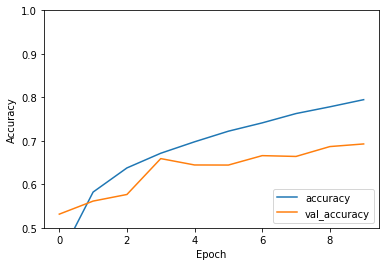

In [59]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

TensorBoard

In [60]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2980), started 1:47:51 ago. (Use '!kill 2980' to kill it.)

<IPython.core.display.Javascript object>

### 3. Предсказание модели <a id='section_3'></a>

Предсказание модели на тестовом датасете

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


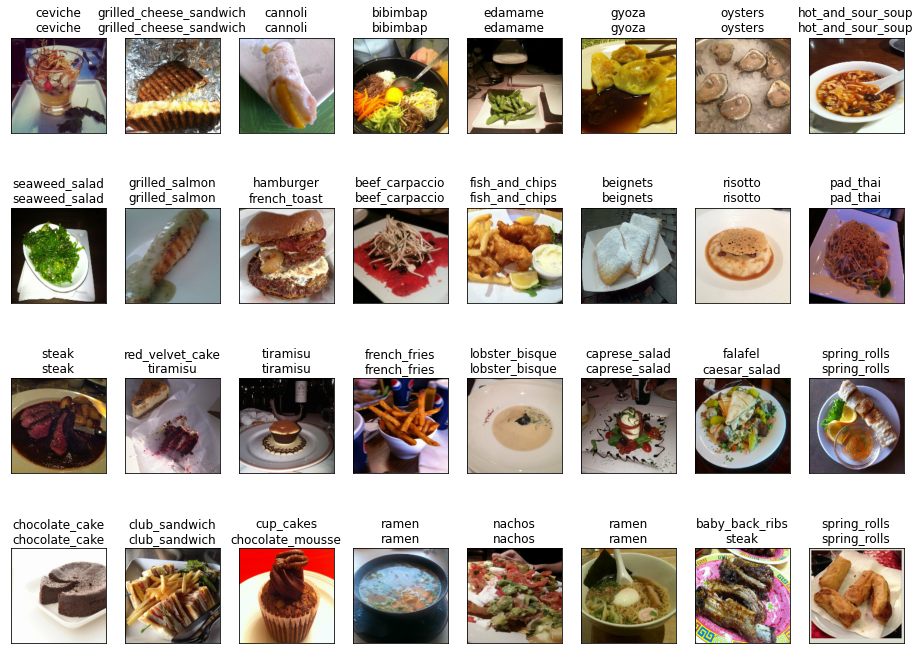

In [63]:
fig = plt.figure(figsize=(16, 12))

for j, (images, labels) in enumerate(iter(test_ds.take(2))): 
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    for i, img in enumerate(numpy_images[:32]):
      ax = fig.add_subplot(4, 8, i+1)
      ax.imshow(((img+1)*127).astype('int'))
      plt.xticks([]), plt.yticks([])

      pred = model(img[None, ...], training=False)
      pred = tf.nn.softmax(pred)
      pred = np.argmax(pred)
      plt.title(get_label_name(numpy_labels[i]) + '\n' + get_label_name(pred))
plt.show()

Предсказание модели на своем изображении

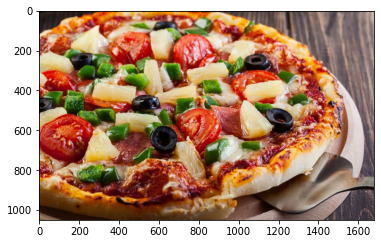

Prediction: pizza


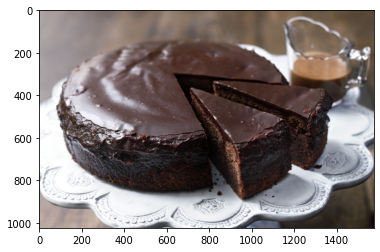

Prediction: chocolate_cake


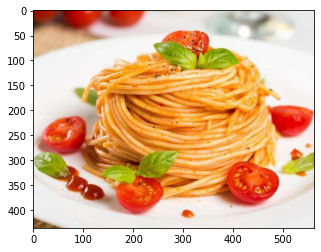

Prediction: chocolate_mousse


In [66]:
import imageio
for image_file in ['pizza.jpg', 'cake.jpg', 'spagetti.jpeg']:
    img = imageio.imread(image_file, pilmode="RGB")
    plt.imshow(img)
    plt.show()
    
    img = resize_and_rescale(img)
    pred = model(img[None, ...], training=False)
    pred = tf.nn.softmax(pred)
    pred = np.argmax(pred)
    print('Prediction: {}'.format(get_label_name(pred)))

**Вывод:** применение аугментации позволяет существенно снизить переобучение модели.